# Train sentiment analysis model

In [1]:
import pandas as pd
from sentiment_analysis_model import SentimentAnalysisModel
    
data = pd.read_csv('./data/Finance_data.csv')
sentiment_analysis_model = SentimentAnalysisModel(data).preprocess_data().train_model()

/usr/local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Preprocess tesla dataframe 

In [2]:
from utils import ast_to_est
from datetime import datetime as dt
tesla_data2 = pd.read_csv('./data/2021.csv', sep=',')
tesla_data = pd.read_csv('./data/2022.csv', sep=',')
# Concatenate two dataframes
tesla_data = pd.concat([tesla_data, tesla_data2])

# For each line in data, only select lines that contain the word "tesla"
tesla = tesla_data[tesla_data['tweet'].str.contains('[t|T]esla')]

# Create a new column that contains the date and time in EST
tesla['created_at_est'] = tesla['created_at'].apply(ast_to_est) 

# Drop all rows before 2021-04-15 (which is ~730 days before today)
# TODO: Make this dynamic instead of relying on a hardcoded date
tesla = tesla[tesla['created_at_est'] >= '2021-04-15 00:00:00']


/var/folders/xr/6zg9zg9d2jx2957vpypkzfqm0000gn/T/ipykernel_87717/1338755879.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla['created_at_est'] = tesla['created_at'].apply(ast_to_est)


# Create sentiment score labels for tesla dataframe

In [3]:
# Using the tesla dataframe, create a new dataframe that contains the polarity score for each example
# Create a new column that contains the polarity score for each example
# Positive shall be 1 and negative shall be 0
tesla['polarity'] = tesla['tweet'].apply(lambda x: 1 if sentiment_analysis_model.predict(x)[0] == 'positive' else 0)


# Drop all columns except for the date and polarity
tesla = tesla[['created_at_est', 'polarity', 'tweet']]
tesla.to_csv('./tesla.csv', index=False)


# Create price prediction dataset


In [4]:
from get_price_data import PriceDataRetrieverAndPreprocessor
import datetime as dt

# Get the minimum and maximum dates
start = tesla['created_at_est'].min()
end = tesla['created_at_est'].max()    

interval = '60m'
ticker = 'TSLA'

df = PriceDataRetrieverAndPreprocessor(ticker, start, end, polarity_score_df=tesla, interval=interval).retrieve().preprocess()
# print(df)
df.to_csv('./df.csv', index=False)
label = 'Price polarity over interval'
y = df[label].values
X = df.drop([label],axis=1).values


Mean Cross Validation Score: 0.7
Accuracy: 0.41935483870967744
Precision: 0.35714285714285715
Recall: 0.35714285714285715
F1: 0.35714285714285715
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.47      0.47        17
           1       0.36      0.36      0.36        14

    accuracy                           0.42        31
   macro avg       0.41      0.41      0.41        31
weighted avg       0.42      0.42      0.42        31



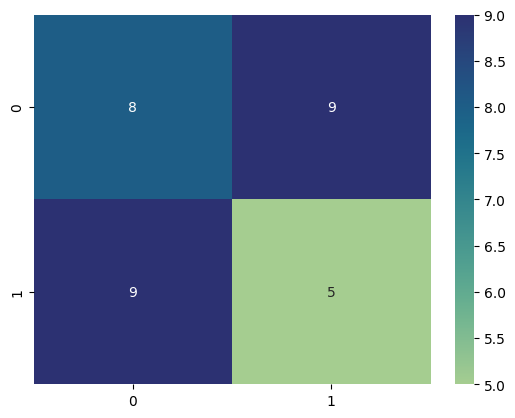

In [5]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import seaborn as sns
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)
model = DecisionTreeClassifier(random_state=0, criterion="gini")
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Mean Cross Validation Score:", np.mean(scores))

model = DecisionTreeClassifier(random_state=0, criterion="gini")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Confusion Matrix:")
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix,annot = True,fmt='g',cmap="crest")

print("Classification Report:")
print(classification_report(y_test, y_pred))